# Análise da performance dos jogadores de basquete ao longo do tempo      

    Feito por Diogo Duarte e Pedro Dannecker                                            

Ao longo do tempo, o modo de se jogar basquete vai se alterando. Podemos dizer isso, visto que nas décadas de 80/90 era preferível jogadores mais altos, e hoje em dia, não necessariamente se busca pessoas grandes. Podemos usar como exemplo o Stephan Curry, jogador o qual não é alto comparado aos seus companheiros de time, chegando a 1,90 metros

Tema ML:
Análise da performace/estilo/saúde dos jogadores de basquete ao longo do tempo.


### Bibliotecas importadas

In [16]:
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras

### Lendo o dataset

In [17]:
df=pd.read_csv("data/all_seasons.csv")

### Preparação para a análise

Estamos querendo analisar em diferentes épocas

In [124]:
# Ajustando os valores de season para conseguir fazer comparação

df['season'] = df['season'].str.extract(r'(\d{4})')

# Definindo DataFrames que correspondem as diferentes décadas

df_decada1990 = df[df['season'] < '2000']

df_decada2000 = df[(df['season'] >= '2000') & (df['season'] < '2010')]

df_decada2010 = df[(df['season'] >= '2010') & (df['season'] < '2020')]

df_decada2020 = df[df['season'] >= '2020']


### Ánalise nas diferentes épocas

In [130]:
corr_1990 = df_decada1990.corr(numeric_only=True)
corr_2000 = df_decada2000.corr(numeric_only=True)
corr_2010 = df_decada2010.corr(numeric_only=True)
corr_2020 = df_decada2020.corr(numeric_only=True)

<Axes: >

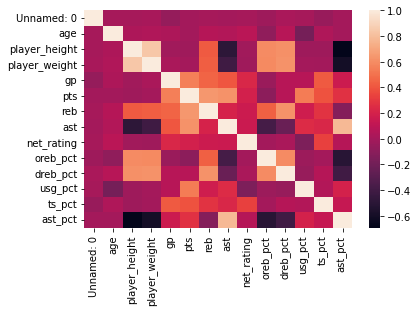

In [131]:
sns.heatmap(corr_1990, xticklabels=corr.columns, yticklabels=corr.columns)

<Axes: >

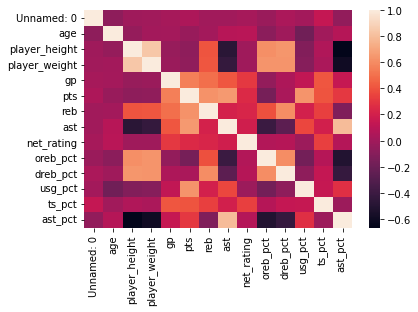

In [132]:
sns.heatmap(corr_2000, xticklabels=corr.columns, yticklabels=corr.columns)

<Axes: >

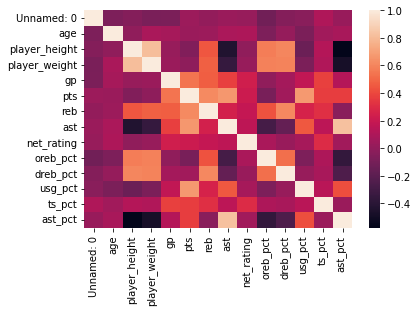

In [133]:
sns.heatmap(corr_2010, xticklabels=corr.columns, yticklabels=corr.columns)

<Axes: >

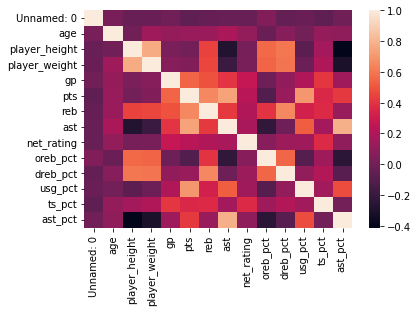

In [134]:
sns.heatmap(corr_2020, xticklabels=corr.columns, yticklabels=corr.columns)

### Ánalise dos pesos de alguns fatores

In [52]:
df_new=df[['draft_number','player_height', 'player_weight', 'gp']]
df_new['draft_number'] = df_new['draft_number'].replace('Undrafted', 0).astype(int)
df_new

C:\Users\diogo\AppData\Local\Temp\ipykernel_52788\1502541067.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['draft_number'] = df_new['draft_number'].replace('Undrafted', 0).astype(int)


,draft_number,player_height,player_weight,gp
0,27,198.12,99.790240,55
1,24,215.90,117.933920,15
2,58,205.74,95.254320,9
3,9,203.20,100.697424,64
4,10,205.74,108.862080,27
...,...,...,...,...
12300,13,205.74,111.130040,17
12301,1,193.04,94.800728,18
12302,6,193.04,99.790240,71
12303,0,195.58,92.986360,12


In [53]:
lista = df_new.values.tolist()
for i in range(len(lista)):
    first_item = lista[i][0]
    remaining_items = lista[0][1:]
    combined_list = [first_item, remaining_items]
    lista.pop(0)
    lista.append(combined_list)
# print(lista)

# Aqui basicamente eu deixei a lista do formato que a função, que o professor fez, recebe

In [46]:
NUM_PAIRS = 4096
def make_paired_dataset(num_pairs, data):
    num_samples = len(data)
    pairs = []
    comparisons = []
    for _ in range(num_pairs):
        i = np.random.randint(num_samples)
        j = np.random.randint(num_samples)
        rank_i, xi = data[i]
        rank_j, xj = data[j]
        pairs.append(np.stack([xi, xj], axis=1))
        comparisons.append(1 if rank_i < rank_j else 0)

    pairs = tf.convert_to_tensor(pairs, dtype=tf.float64)
    comparisons = tf.convert_to_tensor(comparisons, dtype=tf.float64)
    return pairs, comparisons


pairs, comparisons = make_paired_dataset(NUM_PAIRS, lista)

In [47]:
size = int(pairs.shape[1])


def make_base_model(size):
    inputs = keras.layers.Input(shape=(size, ))
    x = keras.layers.Dense(1, use_bias=False, name='dense')(inputs)
    return keras.Model(inputs=inputs, outputs=x, name='base_model')


def make_model(size):
    base_model = make_base_model(size)
    input_1 = keras.layers.Input(shape=(size, ))
    input_2 = keras.layers.Input(shape=(size, ))
    x1 = base_model(input_1)
    x2 = base_model(input_2)
    d = x1 - x2
    s = keras.activations.sigmoid(d)
    model = keras.Model(inputs=[input_1, input_2], outputs=s)
    return model

In [48]:
weight_list = []
num_experiments = 10

for _ in range(num_experiments):
    model = make_model(size)
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    history = model.fit(
        [pairs[:, :, 0], pairs[:, :, 1]],
        comparisons,
        epochs=100,
        batch_size=128,
        verbose=0,
    )
    x = model.layers[2].layers[1].weights[0].numpy()
    x = x / np.linalg.norm(x)
    weight_list.append(x)

In [49]:
weight_list

[array([[-0.878836  ],
        [ 0.46996295],
        [-0.08235367]], dtype=float32),
 array([[-0.8503117 ],
        [ 0.52485985],
        [-0.03862802]], dtype=float32),
 array([[-0.84571713],
        [ 0.49881482],
        [-0.18959509]], dtype=float32),
 array([[-0.7418636 ],
        [ 0.5765232 ],
        [-0.34243166]], dtype=float32),
 array([[-0.8539448 ],
        [ 0.51175207],
        [-0.09427669]], dtype=float32),
 array([[-0.63393366],
        [ 0.7629873 ],
        [-0.1264052 ]], dtype=float32),
 array([[-0.7376735 ],
        [ 0.49586314],
        [-0.45821112]], dtype=float32),
 array([[-0.852495  ],
        [ 0.50649273],
        [-0.12929592]], dtype=float32),
 array([[-0.82299984],
        [ 0.48092657],
        [-0.30229273]], dtype=float32),
 array([[-0.86163735],
        [ 0.5000642 ],
        [-0.08669959]], dtype=float32)]